# **Ouroboros fMRI: Predicting human brain activity with machine learning models**

#### Version: 10th March 2021

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

The first version of this project (17th February 2021) was presented as a Capstone Project for the COS in Applied Data Science: Machine Learning of the EPFL Extension School (https://www.extensionschool.ch/).

==============================================================================================

This project is presented through six Notebooks:

*01: Data Analysis*

*02: Classification* (all classification models except neural networks)

*03: Neural Networks*

***04: Regression***

*05: Results*

*06: Complements*

==============================================================================================

### Notebook 04

# **Regression**

## **1. Introduction to Regression**

### 1.1 Objective

The objective of this project is to address the general question: **Can we train machine learning models to recognize and predict brain activity?** This problem can be seen both as a classification and a regression challenge. 

As a regression challenge, the specific question can be defined this way: **Can we accurately predict the value of a specific voxel or cluster, based on all the other values of the statistical map?** In our case, the voxel or cluster of interest will be defined as the voxel or cluster that shows the highest difference between two experimental conditions: the condition 'good' minus the condition 'bad'. In a typical neuroimaging analysis pipeline, computing differences between experimental conditions is a very common operation, and the resulting statistical map is referred to as a **contrast**. Identifying the voxel that shows the highest value in a given statistical map or contrast, or even within a single cluster, is also a very common operation, and this voxel is referred to as the **peak voxel**. 

Therefore, our approach will be to fit a series of regression models on a train set made of all the voxel (or cluster) values for a certain number of images, and then use these models to predict the value of a voxel of interest for a new, unseen set of images, by giving these models all the voxel values except the value of this voxel of interest. Then, we will verify how accurate the predictions of the models are, compared to a baseline prediction, which will be the mean value of the voxel of interest computed in the train set. In a final section, we will do again these operations, not for a single voxel, but for all the clusters obtained after the voxel size rescaling by a factor 4. 

### 1.2 Models

We will use three regression models and fine-tune their hyperparameters when relevant: **linear regression model**, **linear regression with Huber loss**, **Ridge regression**. By default, we will fit the models using the statistical maps with the original voxel size, but if the computations are too heavy, the stastistical maps with the rescaled voxel size can also be selected in the data import section. First, we will run the models on the **peak voxel (or cluster)**, taking only the statistical map values as features. Then, we will run again the models on the peak voxel, but this time we will add to the features three **categorical variables**, representing the experimental condition (good, neutral or bad) associated to the statistical map. In the final section, we will use only linear regression without the categorical variables. 

### 1.3 Summary

Here is a summary of the features and target variables in classification models and regression models: 

Classification models  | Regression models
------------- | -------------
*Features*: statistical maps  | *Features:* value of all voxels/clusters except the voxel/cluster of interest
*Target*: condition of interest (good, neutral, bad)  | *Target:* value of the voxel/cluster of interest

And here is a general overview of the major preprocessing, model training, model testing and model comparison steps in this project:

Classification models (except neural networks)  | Classification models (neural networks)  | Regression models
------------- | ------------- | -------------
Rescale voxel size: optional  | Rescale voxel size: optional  | Rescale voxel size: optional
Split into train+valid (X) and test (X_te) sets  | Split into train+valid (X) and test (X_te) sets  | Split into train+valid (X) and test (X_te) sets
Flatten the arrays  | Keep the 3D arrays  |  Flatten the arrays
Remove NaN or replace by zero  | Replace NaN by zero | Remove NaN or replace by zero
Fine tuning: grid search with cross-validation  | Neural network training  | Fine tuning: split train+valid (X) into X_tr and X_va
Model comparison: test accuracy  | Model comparison: test accuracy  | Model comparison: MSE
Baseline: level of chance (33%)  | Baseline: level of chance (33%)  | Baseline: mean value of the voxel/cluster obtained from train set

## **2. Functions**

In the following cells, we define a series of functions that will be helpful throughout the Notebook to **display a voxel or cluster position**, **flatten arrays**, **compute metrics**, **perform regressions** and **display graphs** to visualize the accuracy of our predictions. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define a function to return the middle sections of an image data array. 
def middle_sections(image_data):
    return tuple((np.array(image_data.shape) / 2).astype(int))

In [3]:
# Define a function to display the position of a voxel or cluster, with one image as background. 
def display_voxel_or_cluster_position(voxel_index, background_image, image_data_shape, ylim_correction = True):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

    # Sagittal view. 
    axes[0].imshow(background_image[voxel_index[0], :, :].T, origin = 'lower')
    axes[0].axhline(voxel_index[2], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[0].axvline(voxel_index[1], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[0].scatter(voxel_index[1], voxel_index[2], marker = 'o', c = 'white')
    axes[0].set_title('Sagittal view')

    # Coronal view. 
    axes[1].imshow(background_image[:, voxel_index[1], :].T, origin = 'lower')
    axes[1].axhline(voxel_index[2], 0, image_data_shape[0], color = 'yellow') # Horizontal line through sagittal view. 
    axes[1].axvline(voxel_index[0], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[1].scatter(voxel_index[0], voxel_index[2], marker = 'o', c = 'white')
    if ylim_correction == True:
        axes[1].set_ylim(8, 83) # We adjust the size for a better visualization. 
    axes[1].set_title('Coronal view')

    # Axial view. 
    axes[2].imshow(background_image[:, :, voxel_index[2]], origin = 'lower')
    axes[2].axhline(voxel_index[0], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[2].axvline(voxel_index[1], 0, image_data_shape[0], color = 'yellow') # Vertical line through sagittal view. 
    axes[2].scatter(voxel_index[1], voxel_index[0], marker = 'o', c = 'white')
    axes[2].set_title('Axial view')
    plt.show();

In [4]:
# Define a function to flatten features variables. 
def flatten_features_variables(X_convnet, X_convet_te, image_data_shape):
    # Create NumPy arrays. 
    X_regression = np.zeros((X_convnet.shape[0], np.prod(image_data_shape)))
    X_regression_te = np.zeros((X_convnet_te.shape[0], np.prod(image_data_shape)))

    # Fill in the array for the train+valid set. 
    for image_index in range(X_convnet.shape[0]):
        # Flatten image. 
        image_flatten = X_convnet[image_index, :, :, :].flatten()

        # Store the flatten image in the new array. 
        X_regression[image_index] = image_flatten

    # Fill in the array for the test set. 
    for image_index in range(X_convnet_te.shape[0]):
        # Flatten image. 
        image_flatten = X_convnet_te[image_index, :, :, :].flatten()

        # Store the flatten image in the new array. 
        X_regression_te[image_index] = image_flatten

    return X_regression, X_regression_te

In [5]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [6]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [7]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [8]:
# Define a function to run a linear regression. 
def linear_regression(X_regression, X_regression_te, y_regression, y_regression_te):
    # Run linear regression. 
    lr = LinearRegression()
    lr.fit(X_regression, y_regression)
    y_pred_lr = lr.predict(X_regression_te)
    mse_lr = MSE(y_regression_te, y_pred_lr)
    mae_lr = MAE(y_regression_te, y_pred_lr)
    rss_lr = RSS(y_regression_te, y_pred_lr)
    print('MSE linear regression:', mse_lr)
    print('MAE linear regression:', mae_lr)
    print('RSS linear regression:', rss_lr)

    # Compute the R^2 measure. 
    r2_lr = 1 - (rss_lr / rss_baseline)
    print('R^2 linear regression: ' + str(r2_lr))
    
    return y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr

In [9]:
# Define a function to run a regression with Huber loss, with the default epsilon value. 
def huber_loss(X_regression, X_regression_te, y_regression, y_regression_te):
    # Run regression with Huber loss. 
    huber = HuberRegressor(epsilon = 1.35)
    huber.fit(X_regression, y_regression)
    y_pred_huber = huber.predict(X_regression_te)
    mse_huber = MSE(y_regression_te, y_pred_huber)
    mae_huber = MAE(y_regression_te, y_pred_huber)
    rss_huber = RSS(y_regression_te, y_pred_huber)
    print('MSE Huber loss:', mse_huber)
    print('MAE Huber loss:', mae_huber)
    print('RSS Huber loss:', rss_huber)

    # Compute the R^2 measure. 
    r2_huber = 1 - (rss_huber / rss_baseline)
    print('R^2 Huber loss: ' + str(r2_huber))
    
    return y_pred_huber, mse_huber, mae_huber, rss_huber, r2_huber

In [10]:
# Define a function to fine-tune a Ridge regression. 
def fine_tune_ridge_regression(X_regression, X_regression_te, y_regression, y_regression_te, alpha_values):
    # Define alpha parameters to explore.  
    gs_results = []

    # Fine-tune Ridge regression with a grid search. 
    for alpha in alpha_values:
        for run_idx in range(5):
            # Create Ridge regression. 
            ridge = Ridge(alpha = alpha)

            # Split into train / valid sets. 
            X_regression_tr, X_regression_va, y_regression_tr, y_regression_va = train_test_split(
                X_regression, y_regression, test_size = 0.2, random_state = run_idx)

            # Fit the model. 
            ridge.fit(X_regression_tr, y_regression_tr)

            # Save alpha value and model performance on train and validaton sets. 
            gs_results.append({
                'alpha': alpha,
                'train_mse': MSE(y_regression_tr, ridge.predict(X_regression_tr)),
                'valid_mse': MSE(y_regression_va, ridge.predict(X_regression_va)),
            })
            
    return gs_results

In [11]:
# Define a function to display the results of the Ridge regression fine-tuning. 
def display_ridge_fine_tuning_results(gs_results, alpha_values):
    # Convert results to DataFrame. 
    gs_results = pd.DataFrame(gs_results)

    # Group results by alpha value. 
    grouped = gs_results.groupby('alpha')

    # Compute train / valid mean scores with std. 
    mean_tr = grouped.train_mse.mean()
    mean_va = grouped.valid_mse.mean()
    std_tr = grouped.train_mse.std()
    std_va = grouped.valid_mse.std()

    # Plot the validation curves. 
    plt.plot(np.log10(alpha_values), mean_tr, color = 'blue', label = 'train curve')
    plt.plot(np.log10(alpha_values), mean_va, color = 'green', label = 'valid curve')

    # Mark best alpha value. 
    best_alpha = mean_va.idxmin()
    plt.scatter(np.log10(best_alpha), mean_va.min(), marker = 'x', c = 'green', zorder = 10)

    # Quantify variance with ±std curves. 
    plt.fill_between(np.log10(alpha_values), mean_tr - std_tr, mean_tr + std_tr, color = 'blue', alpha = 0.2)
    plt.fill_between(np.log10(alpha_values), mean_va - std_va, mean_va + std_va, color = 'green', alpha = 0.2)

    # Add title and labels. 
    plt.title('Best alpha: {:.2e} - MSE: {:.4f}'.format(best_alpha, mean_va.min()))
    plt.xlabel('$log_{10}(alpha)$')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    
    return best_alpha

In [12]:
# Define a function to run a Ridge regression. 
def ridge_regression(X_regression, X_regression_te, y_regression, y_regression_te, best_alpha):
    # Run Ridge regression with the best alpha. 
    ridge = Ridge(alpha = best_alpha)
    ridge.fit(X_regression, y_regression)
    y_pred_ridge = ridge.predict(X_regression_te)
    mse_ridge = MSE(y_regression_te, y_pred_ridge)
    mae_ridge = MAE(y_regression_te, y_pred_ridge)
    rss_ridge = RSS(y_regression_te, y_pred_ridge)
    print('MSE Ridge regression:', mse_ridge)
    print('MAE Ridge regression:', mae_ridge)
    print('RSS Ridge regression:', rss_ridge)

    # Compute the R^2 measure. 
    r2_ridge = 1 - (rss_ridge / rss_baseline)
    print('R^2 Ridge regression: ' + str(r2_ridge))
    
    return y_pred_ridge, mse_ridge, mae_ridge, rss_ridge, r2_ridge

In [13]:
# Define a function to display statistics about the predictions. 
def display_statistics_about_predictions(y_regression_te, y_pred_lr, y_pred_huber, y_pred_ridge):
    fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (13, 20))

    # Display the distribution of true values and predictions in four graphs. 
    axes[0, 0].hist(y_regression_te, bins = 20, color = 'tab:blue')
    axes[0, 0].set_title('True values from the test set')
    axes[0, 1].hist(y_pred_lr, bins = 20, color = 'tab:green')
    axes[0, 1].set_title('Predictions from linear regression')
    axes[1, 0].hist(y_pred_huber, bins = 20, color = 'tab:green')
    axes[1, 0].set_title('Predictions from Huber loss')
    axes[1, 1].hist(y_pred_ridge, bins = 20, color = 'tab:green')
    axes[1, 1].set_title('Predictions from Ridge regression')

    # Display the distribution of true values and predictions in a single graph. 
    axes[2, 0].hist(y_regression_te, bins = 20, color = 'tab:blue', alpha = 0.75)
    axes[2, 0].hist(y_pred_lr, bins = 20, color = 'tab:green', alpha = 0.5)
    axes[2, 0].hist(y_pred_huber, bins = 20, color = 'tab:green', alpha = 0.5)
    axes[2, 0].hist(y_pred_ridge, bins = 20, color = 'tab:green', alpha = 0.5)
    axes[2, 0].set_title('True values and predictions')

    # Display scatter plots of true values vs predictions. 
    axes[2, 1].scatter(y_regression_te, y_pred_lr)
    axes[2, 1].set_title('True values vs predictions from linear regression')
    axes[3, 0].scatter(y_regression_te, y_pred_huber)
    axes[3, 0].set_title('True values vs predictions from Huber loss')
    axes[3, 1].scatter(y_regression_te, y_pred_ridge)
    axes[3, 1].set_title('True values vs predictions from Ridge regression');

## **3. Data import**

In this Notebook, instead of the flattened features arrays, we **reuse the 3D arrays** that we used for the convolutional neural networks, because we want to display the position of the voxel or cluster of interest before running our models. Therefore, we will have to perform again some preprocessing: flatten the arrays and remove all the voxels/clusters that always equal zero. 

In [14]:
# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_fmri_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [15]:
# Select rescale mode. 
# 1: original data | 2, 3, 4: voxel size rescaled by a factor 2, 3 or 4. 
rescale_mode = 1

In [16]:
# Load data. 
with np.load(preprocessed_data_path + 'datasets_for_machine_learning.npz', allow_pickle = False) as npz_file:
    data_dict = dict(npz_file.items())
rescale_modes_list = ['', '_r2', '_r3', '_r4']
    
# Features of the train+valid dataset. 
X_convnet = data_dict['features_convnet' + rescale_modes_list[rescale_mode - 1] + '_tr']

# Features of the test dataset. 
X_convnet_te = data_dict['features_convnet' + rescale_modes_list[rescale_mode - 1] + '_te']

# Target variables. 
y = data_dict['target_tr']
y_te = data_dict['target_te']

In [17]:
# Display the size of the arrays. 
print('X_convnet:   ', X_convnet.shape)
print('X_convnet_te:', X_convnet_te.shape)
print('y:           ', y.shape)
print('y_te:        ', y_te.shape)

X_convnet:    (120, 91, 109, 91)
X_convnet_te: (36, 91, 109, 91)
y:            (120,)
y_te:         (36,)


## **4. Peak voxel or cluster**

In the following cells, we compute and display information about the **peak voxel** (or peak cluster). We also compute the correlation coefficients between this peak voxel and all the other voxels in our statistical maps. Finally, we prepare our features matrixes for the regression models. 

In [18]:
# Display the shape of the first image data array. 
image_data = X_convnet[0, :, :, :]
image_data.shape

(91, 109, 91)

In [19]:
# Find the middle sections coordinates. 
middle_coord = middle_sections(image_data)
middle_coord

(45, 54, 45)

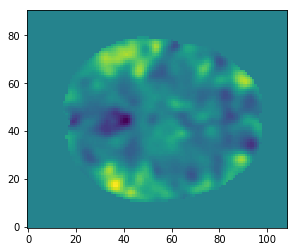

In [20]:
# Display a section of the image with an axial view, using the middle sections coordinates. 
plt.imshow(image_data[:, :, middle_coord[2]], origin = 'lower');

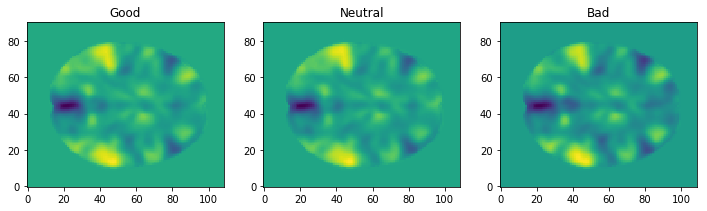

In [21]:
# Compute the sum of the images for the good, neutral and bad conditions. 
sum_image_data_good = np.sum(X_convnet[y == 'good', :, :, :], axis = 0)
sum_image_data_neutral = np.sum(X_convnet[y == 'neutral', :, :, :], axis = 0)
sum_image_data_bad = np.sum(X_convnet[y == 'bad', :, :, :], axis = 0)

# Display the sum images. 
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
axes[0].imshow(sum_image_data_good[:, :, middle_coord[2]], origin = 'lower')
axes[0].set_title('Good')
axes[1].imshow(sum_image_data_neutral[:, :, middle_coord[2]], origin = 'lower')
axes[1].set_title('Neutral')
axes[2].imshow(sum_image_data_bad[:, :, middle_coord[2]], origin = 'lower')
axes[2].set_title('Bad');

As we discussed during the EDA, it is difficult to visually identify differences between the conditions, even in these sum images. Nevertheless, we can subtract one condition from another in order to get a **contrast**. In this contrast, the voxel with the maximum value is the **peak voxel**. 

In [22]:
# Find the value of the voxel or cluster with the maximum difference between the good and bad conditions. 
peak_voxel = np.max(sum_image_data_good - sum_image_data_bad)
peak_voxel

95.51738381385803

In [23]:
# Find the index of this voxel or cluster in the flatten array. 
peak_voxel_flatten_idx = np.argmax(sum_image_data_good - sum_image_data_bad)
peak_voxel_flatten_idx

627598

In [24]:
# Find the indexes of this voxel or cluster in the 3D array. 
peak_voxel_idx = np.unravel_index(np.argmax(sum_image_data_good - sum_image_data_bad), image_data.shape)
peak_voxel_idx

(63, 29, 62)

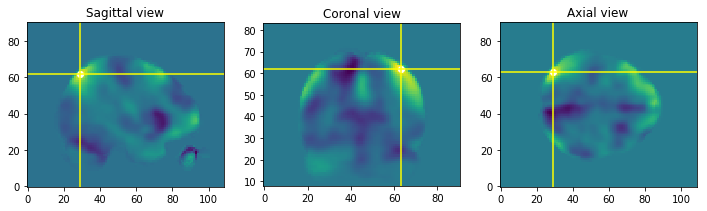

In [25]:
# Display the position of this voxel or cluster. 
# As a background image, we use the difference between the sum images for the good and bad conditions. 
display_voxel_or_cluster_position(peak_voxel_idx, sum_image_data_good - sum_image_data_bad, image_data.shape)

Here we can visualize the **position of the peak voxel** inside the brain, and verify that it is located in a region where the differences between the good and bad conditions are high. 

In [26]:
# Get the value of this voxel or cluster through all images. 
peak_voxel_value_through_all_images = X_convnet[:, peak_voxel_idx[0], peak_voxel_idx[1], peak_voxel_idx[2]]
map_corrcoef = np.zeros((image_data.shape))

# Loop over all voxels or clusters, and compute their correlation with our voxel or cluster of interest. 
for sagittal_index in range(0, image_data.shape[0]):
    for coronal_index in range(0, image_data.shape[1]):
        for axial_index in range(0, image_data.shape[2]):
            voxel_value_through_all_images = X_convnet[:, sagittal_index, coronal_index, axial_index]
            if np.sum(voxel_value_through_all_images == np.zeros(120)) != 120:
                voxel_corrcoef = np.corrcoef(voxel_value_through_all_images, peak_voxel_value_through_all_images)[0, 1]
                map_corrcoef[sagittal_index, coronal_index, axial_index] = voxel_corrcoef

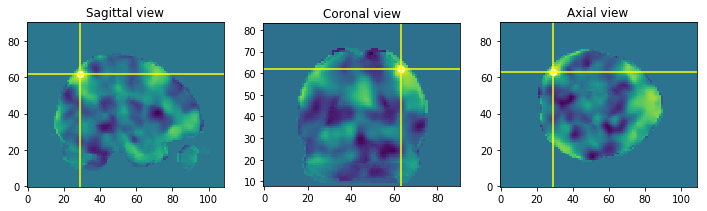

In [27]:
# Display the position of this voxel or cluster, taking the map of correlation coefficients as a background image. 
display_voxel_or_cluster_position(peak_voxel_idx, map_corrcoef, image_data.shape)

Here we can visualize the **correlations between the peak voxel and the other brain regions**. In neuroimaging, it is generally observed that contiguous voxels show a similar behavior. But at a larger scale, neuroimaging studies often identify **networks of regions** that work together throughout the brain. And indeed, our maps show that the peak voxel correlates with its immediate neighbors, but also with more distant brain regions. 

In [28]:
# Flatten features variables. 
X_regression, X_regression_te = flatten_features_variables(X_convnet, X_convnet_te, image_data.shape)

In [29]:
# Display the shape of the arrays. 
print('X_regression:   ', X_regression.shape)
print('X_regression_te:', X_regression_te.shape)

X_regression:    (120, 902629)
X_regression_te: (36, 902629)


In [30]:
# Security check: verify again the voxel or cluster with the maximum difference between the good and bad conditions. 
check_peak_voxel = np.max(np.sum(X_regression[y == 'good', :], axis = 0) - np.sum(X_regression[y == 'bad', :], axis = 0))
check_peak_voxel

95.51738381385803

In [31]:
# Verify that this is the same result as before. 
check_peak_voxel == peak_voxel

True

In [32]:
# Extract the target variable. 
y_regression = X_regression[:, peak_voxel_flatten_idx]
y_regression_te = X_regression_te[:, peak_voxel_flatten_idx]

# Remove the target variable from the features array. 
X_regression = np.delete(X_regression, peak_voxel_flatten_idx, 1)
X_regression_te = np.delete(X_regression_te, peak_voxel_flatten_idx, 1)

In [33]:
# Display the shape of the arrays. 
print('X_regression:   ', X_regression.shape)
print('X_regression_te:', X_regression_te.shape)
print('y_regression:   ', y_regression.shape)
print('y_regression_te:', y_regression_te.shape)

X_regression:    (120, 902628)
X_regression_te: (36, 902628)
y_regression:    (120,)
y_regression_te: (36,)


In [34]:
# Security check: verify that the maximum difference between the good and bad conditions is now different. 
different_peak_voxel = np.max(np.sum(X_regression[y == 'good', :], axis = 0) - np.sum(X_regression[y == 'bad', :], axis = 0))
different_peak_voxel

95.31292355060577

In [35]:
# Verify that the result is indeed different from before. 
different_peak_voxel != peak_voxel

True

In [36]:
# Retrieve all the indexes where the features always equal zero. 
# We use the 'any' method, which returns True for non-zero numbers and False for zero numbers. 
all_zeros_idx = ~X_regression.any(axis = 0)

# Display the number of features that always equal zero. 
np.sum(all_zeros_idx)

651279

In [37]:
# Security check: display the predicted dimensionality once we remove these features. 
predicted_dimensionality = X_regression.shape[1] - np.sum(all_zeros_idx)
predicted_dimensionality

251349

In [38]:
# Remove these features from the features arrays. 
X_regression = np.delete(X_regression, np.where(all_zeros_idx), 1)
X_regression_te = np.delete(X_regression_te, np.where(all_zeros_idx), 1)

In [39]:
# Display the shape of the arrays. 
print('X_regression:   ', X_regression.shape)
print('X_regression_te:', X_regression_te.shape)
print('y_regression:   ', y_regression.shape)
print('y_regression_te:', y_regression_te.shape)

X_regression:    (120, 251349)
X_regression_te: (36, 251349)
y_regression:    (120,)
y_regression_te: (36,)


In [40]:
# Verify that the predicted dimensionality was correct. 
X_regression.shape[1] == X_regression_te.shape[1] == predicted_dimensionality

True

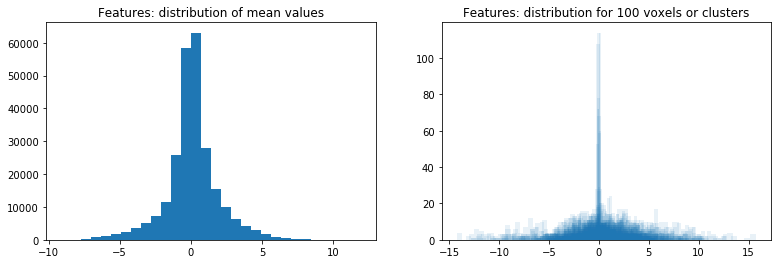

In [41]:
# Display statistics about features with histograms. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4))

# Display the distribution of mean values per voxel or cluster. 
axes[0].hist(np.mean(X_regression, axis = 0), bins = 30)
axes[0].set_title('Features: distribution of mean values')

# Display the distribution of values for a selection of 100 voxels or clusters. 
for voxel_index in range(0, X_regression.shape[1], int(X_regression.shape[1] / 100)):
    axes[1].hist(X_regression[:, voxel_index], bins = 30, color = 'tab:blue', alpha = 0.1)
axes[1].set_title('Features: distribution for 100 voxels or clusters');

The distribution of the values in our features matrix seems to be **relatively symmetrical, with no significant skewness**. Even after removing the features that were always equal to zero, a high number of zero values remains visible, which was expected. As we discussed in the first Notebook about Data Analysis, since the position of the subjects in the fMRI scanner vary, sometimes the brains can move slightly outside the fMRI scope, and when that happens, subjects can have missing data. In the same Notebook, we also discussed the fact that replacing these missing values by zero seems to be a good strategy, since by construction, zero corresponds to the absence of any correlation or anti-correlation. Overall, considering the distribution of the values, there seem to be **no strong rationale to add additional data cleaning or feature engineering**, and we can reasonably use the features as they are. 

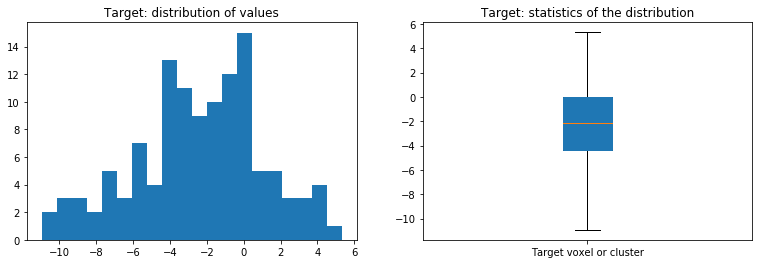

In [42]:
# Display statistics about target with a histogram and a boxplot. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4))

# Display the distribution of values. 
axes[0].hist(y_regression, bins = 20)
axes[0].set_title('Target: distribution of values')
axes[1].boxplot(y_regression)
axes[1].boxplot(y_regression, patch_artist = True,
                boxprops = dict(facecolor = 'tab:blue', color = 'tab:blue'),
                flierprops = dict(color = 'tab:blue', markeredgecolor = 'tab:blue'))
axes[1].set_xticklabels(['Target voxel or cluster'])
axes[1].set_title('Target: statistics of the distribution');

If we run this Notebook using the data without rescaling, the distribution of the values in our target array seems also to be **relatively symmetrical, with no significant skewness**. Nevertheless, we must be aware that running this Notebook with a voxel size rescaling of factor 2, 3 or 4 will produce different results. In particular, the position of the peak voxel (or cluster) can be entirely different depending on the rescaling factor. Overall, considering the distribution of the values without rescaling, there seem to be **no strong rationale to add "target engineering"**. For the rescaling of factor 2, 3 or 4, the distributions vary but it does not seem that a "target engineering" step would be relevant either. 

## **5. Regression models: one voxel or cluster**

### 5.1 Regressions with numerical variables only

In the following cells, we fit a **linear regression**, a **regression with Huber loss** and a **Ridge regression**, using only the features matrixes that we defined previously, with numerical values. For these three models and for the baseline, we compute the **Mean Average Error (MAE)**, the **Mean Squared Error (MSE)** and the **Residual Sum of Squares (RSS)**. As the baseline, we take the mean of the values taken by the peak voxel in the train set. We fine-tune the alpha hyperparameter of the Ridge regression using MSE, and in the last section of this Notebook, we will compare the predictability of each cluster using RSS. Since MSE and RSS both measure the squares of the residuals, choosing the mean as the baseline seems consistent. 

By default we don't apply standardization on the features, since it does not improve the results and the statistical maps are already normalized through the neuroimaging analysis pipeline. For the Ridge regression, several sources indicate that the results may be odd when the dimensionality is high, because the presence of many small independent components can have a regularizing effect equivalent to a Ridge regularization. See for example: https://stats.stackexchange.com/questions/328630/is-ridge-regression-useless-in-high-dimensions-n-ll-p-how-can-ols-fail-to. In order to better evaluate the results from the fine-tuning, we run several iterations for each alpha value to explore. 

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [44]:
# Baseline model: mean of the values taken by the peak voxel in the train set. 
mae_baseline = MAE(y_regression_te, np.mean(y_regression))
mse_baseline = MSE(y_regression_te, np.mean(y_regression))
rss_baseline = RSS(y_regression_te, np.mean(y_regression))
print('MAE baseline:', mae_baseline)
print('MSE baseline:', mse_baseline)
print('RSS baseline:', rss_baseline)

MAE baseline: 1.6141121642172545
MSE baseline: 4.05629237717273
RSS baseline: 146.0265255782183


In [45]:
# Apply or not a standardization step. 0: no. 1: yes. 
standardize_features = 0

# Standardize features. 
if standardize_features == 1:
    scaler = StandardScaler()
    X_regression = scaler.fit_transform(X_regression)
    X_regression_te = scaler.transform(X_regression_te)

In [46]:
# Run a linear regression. 
y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr = linear_regression(
    X_regression, X_regression_te, y_regression, y_regression_te)

MSE linear regression: 2.4213556451030227
MAE linear regression: 1.325399599991828
RSS linear regression: 87.16880322370882
R^2 linear regression: 0.40306185551872675


**Result:** The linear regression model performs better than the baseline model. 

In [47]:
# Run a regression with Huber loss. 
y_pred_huber, mse_huber, mae_huber, rss_huber, r2_huber = huber_loss(
    X_regression, X_regression_te, y_regression, y_regression_te)

MSE Huber loss: 1.6932751199616936
MAE Huber loss: 1.0445938009720122
RSS Huber loss: 60.95790431862097
R^2 Huber loss: 0.582555949494469


**Result:** The regression model with Huber loss performs better than the baseline model. 

In [48]:
# Define the range of alpha values to explore for the Ridge regression. 
alpha_values = np.logspace(-8, 4, num = 13)

In [49]:
# Fine-tune a Ridge regression. 
gs_results = fine_tune_ridge_regression(
    X_regression, X_regression_te, y_regression, y_regression_te, alpha_values)

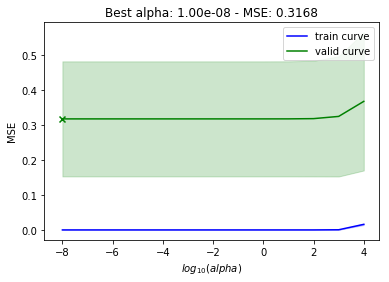

In [50]:
# Display fine-tuning results. 
best_alpha = display_ridge_fine_tuning_results(gs_results, alpha_values)

The validation curve seems to be **flat for most of the alpha values**, and the identification of the best alpha value seems somewhat arbitrary. As we discussed above, this behavior may be due to the high dimensionality of the data. We should also note that exploring lower alpha values raises a Scikit-learn warning about a risk of ill-conditioning. 

In [51]:
# Run a Ridge regression. 
y_pred_ridge, mse_ridge, mae_ridge, rss_ridge, r2_ridge = ridge_regression(
    X_regression, X_regression_te, y_regression, y_regression_te, best_alpha)

MSE Ridge regression: 2.4214418333355683
MAE Ridge regression: 1.3254291912830813
RSS Ridge regression: 87.17190600008045
R^2 Ridge regression: 0.40304060748615633


**Result:** The Ridge regression model performs better than the baseline model. The results are nearly identical to those from the linear regression, probably indicating that the regularization has little effet. 

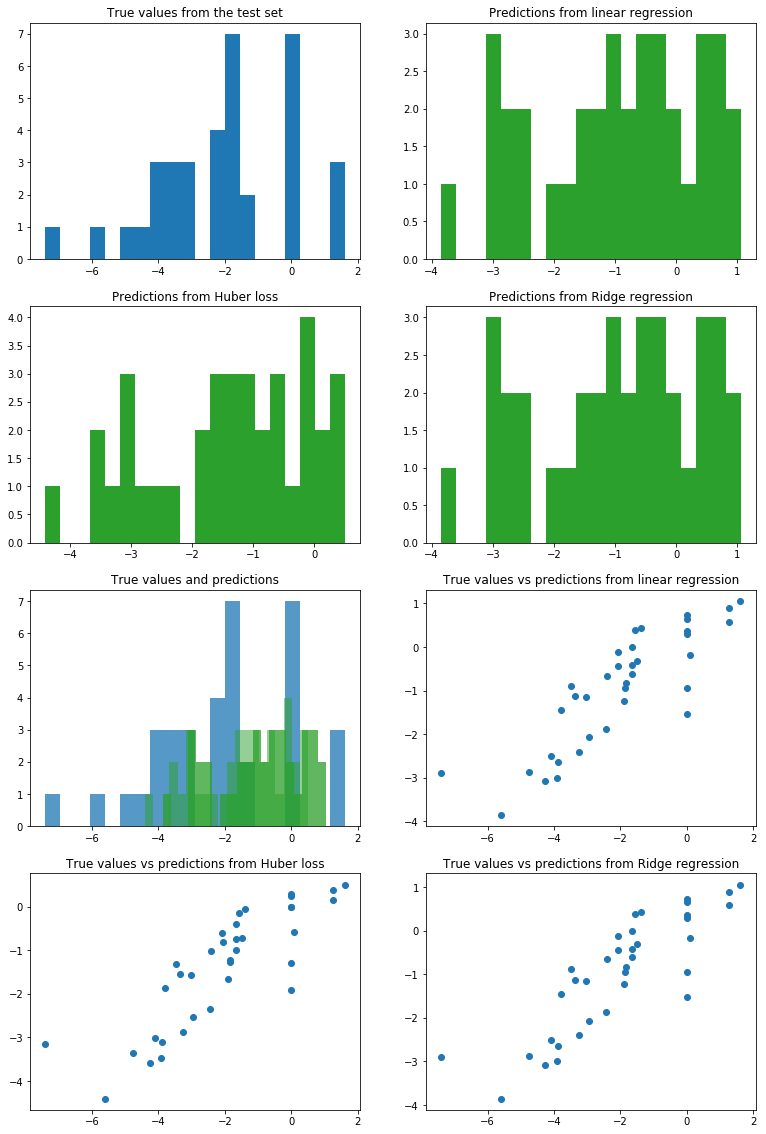

In [52]:
# Display statistics about the predictions. 
display_statistics_about_predictions(y_regression_te, y_pred_lr, y_pred_huber, y_pred_ridge)

The predictions from the different models overlap largely with each other. The overlap with the true values is not perfect, but the models still managed to capture some of the variance. 

### 5.2 Regressions with numerical and categorical variables

In the following cells, we run the same models than before, but this time, we add three additional features. These features correspond to the **categorical variable indicating the experimental condition (good, neutral, bad) associated to the statistical map, processed with one-hot encoding**. We could also have encoded these conditions with ordinal variables, for example bad = 0, neutral = 1, good = 2. But since the EDA did not indicate any sign of an ordering between these variables, it seems wiser to make no such assumption. Additionally, experimental conditions in neuroimaging have often no straightforward interpretation. For example, the neutral condition could actually correspond to a situation where uncertainty is maximal, and this might affect the brain activity in a very different way than the two other conditions. Therefore, assuming a natural ordering from bad to good would have been risky. 

In [53]:
# Display the shape of the arrays. 
print('X_regression:   ', X_regression.shape)
print('X_regression_te:', X_regression_te.shape)

X_regression:    (120, 251349)
X_regression_te: (36, 251349)


In [54]:
# Apply one-hot encoding to the categorical variable indicating the experimental condition in the train+valid set. 
y_one_hot = pd.get_dummies(y)
y_one_hot = y_one_hot[['good', 'neutral', 'bad']].values

# Apply one-hot encoding to the categorical variable indicating the experimental condition in the test set. 
y_one_hot_te = pd.get_dummies(y_te)
y_one_hot_te = y_one_hot_te[['good', 'neutral', 'bad']].values

# Display the shapes of the arrays. 
print('y_one_hot:  ', y_one_hot.shape)
print('y_one_hot_te:', y_one_hot_te.shape)

y_one_hot:   (120, 3)
y_one_hot_te: (36, 3)


In [55]:
# Add the one-hot encoded arrays to the features arrays. 
X_regression_categ = np.concatenate((X_regression, y_one_hot), axis = 1)
X_regression_categ_te = np.concatenate((X_regression_te, y_one_hot_te), axis = 1)

# Display the shape of the arrays. 
print('X_regression_categ:   ', X_regression_categ.shape)
print('X_regression_categ_te:', X_regression_categ_te.shape)

X_regression_categ:    (120, 251352)
X_regression_categ_te: (36, 251352)


In [56]:
# Run a linear regression. 
y_pred_lr_categ, mse_lr_categ, mae_lr_categ, rss_lr_categ, r2_lr_categ = linear_regression(
    X_regression_categ, X_regression_categ_te, y_regression, y_regression_te)

MSE linear regression: 2.4220794440507376
MAE linear regression: 1.3256338951863618
RSS linear regression: 87.19485998582655
R^2 linear regression: 0.40288341696439867


**Result:** Again, the linear regression model performs better than the baseline model. The results are nearly identical to the previous fitting without the categorical variable. 

In [57]:
# Run a regression with Huber loss. 
y_pred_huber_categ, mse_huber_categ, mae_huber_categ, rss_huber_categ, r2_huber_categ = huber_loss(
    X_regression_categ, X_regression_categ_te, y_regression, y_regression_te)

MSE Huber loss: 1.6954154220810573
MAE Huber loss: 1.0515055169848995
RSS Huber loss: 61.03495519491806
R^2 Huber loss: 0.5820282996309117


**Result:** Again, the regression model with Huber loss performs better than the baseline model. The results are nearly identical to the previous fitting without the categorical variable. 

In [58]:
# Fine-tune a Ridge regression. 
gs_results_categ = fine_tune_ridge_regression(
    X_regression_categ, X_regression_categ_te, y_regression, y_regression_te, alpha_values)

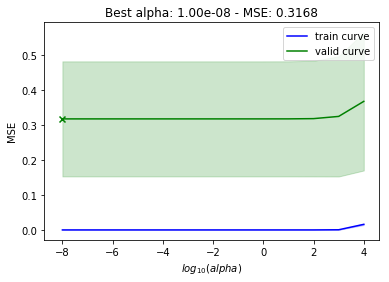

In [59]:
# Display fine-tuning results. 
best_alpha_categ = display_ridge_fine_tuning_results(gs_results_categ, alpha_values)

Again, the validation curve seems to be flat for most of the alpha values. 

In [60]:
# Run a Ridge regression. 
y_pred_ridge_categ, mse_ridge_categ, mae_ridge_categ, rss_ridge_categ, r2_ridge_categ = ridge_regression(
    X_regression_categ, X_regression_categ_te, y_regression, y_regression_te, best_alpha_categ)

MSE Ridge regression: 2.421372053635431
MAE Ridge regression: 1.3254088683738439
RSS Ridge regression: 87.16939393087551
R^2 Ridge regression: 0.4030578103141699


**Result:** Again, the Ridge regression model performs better than the baseline model. The results are nearly identical to those from the linear regression, probably indicating that the regularization has little effet. They are also nearly identical to the previous fitting without the categorical variable. 

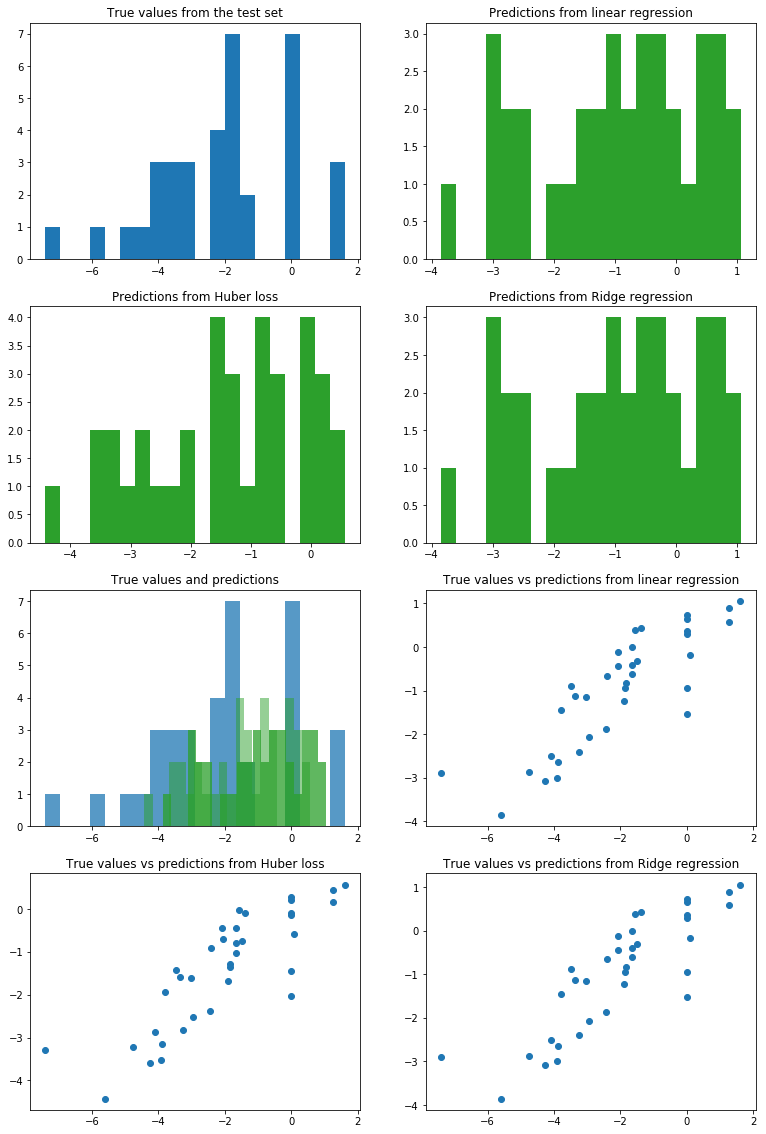

In [61]:
# Display statistics about the predictions. 
display_statistics_about_predictions(y_regression_te, y_pred_lr_categ, y_pred_huber_categ, y_pred_ridge_categ)

Again, the predictions from the different models overlap largely with each other. The overlap with the true values is not perfect, but the models still managed to capture some of the variance. Overall, **adding the categorical variable does not seem to produce a visible effect**. This might be due to the high dimensionality of the data, which could have limited the impact of these few additional features. This might also be due to the fact that the experimental conditions, as we saw in the previous Notebooks, produce only subtle effects on the general activity of the brain, and might not be relevant enough to clearly influence the regression models. 

## **6. Save results**

In [62]:
# Save the results into a .npz file. 
if rescale_mode == 1:
    results_file_name = 'regression_results.npz'
else:
    results_file_name = 'regression_results_r' + str(rescale_mode) + '.npz'

np.savez(results_path + results_file_name, 
         # Test scores: MSE. 
         mse_baseline = mse_baseline, 
         mse_lr = mse_lr, 
         mse_huber = mse_huber, 
         mse_ridge = mse_ridge, 
         mse_lr_categ = mse_lr_categ, 
         mse_huber_categ = mse_huber_categ, 
         mse_ridge_categ = mse_ridge_categ, 
         
         # Test scores: MAE. 
         mae_baseline = mae_baseline, 
         mae_lr = mae_lr, 
         mae_huber = mae_huber, 
         mae_ridge = mae_ridge, 
         mae_lr_categ = mae_lr_categ, 
         mae_huber_categ = mae_huber_categ, 
         mae_ridge_categ = mae_ridge_categ, 
         
         # Test scores: RSS. 
         rss_baseline = rss_baseline, 
         rss_lr = rss_lr, 
         rss_huber = rss_huber, 
         rss_ridge = rss_ridge, 
         rss_lr_categ = rss_lr_categ, 
         rss_huber_categ = rss_huber_categ, 
         rss_ridge_categ = rss_ridge_categ, 
         
         # Model comparison: R^2. 
         r2_lr = r2_lr, 
         r2_huber = r2_huber, 
         r2_ridge = r2_ridge, 
         r2_lr_categ = r2_lr_categ, 
         r2_huber_categ = r2_huber_categ, 
         r2_ridge_categ = r2_ridge_categ, 
         
         # Predictions. 
         y_pred_lr = y_pred_lr, 
         y_pred_huber = y_pred_huber, 
         y_pred_ridge = y_pred_ridge,
         y_pred_lr_categ = y_pred_lr_categ, 
         y_pred_huber_categ = y_pred_huber_categ, 
         y_pred_ridge_categ = y_pred_ridge_categ)

## **7. Regression models: all clusters**

For this last section, the data with a **voxel size rescaling by a factor 4** is used by default. The code works also for the other rescaling modes and for the data without rescaling, but the computations become much heavier. 

In the following cells, we **loop over all the clusters in the brain** and run approximately the same steps than in the previous section: extract the cluster activity as the target variable, remove it from the features matrix, compute the baseline by taking the mean value of this cluster in the train set, compute the RSS of the baseline, and finally run a linear regression and measure its coefficient of determination R^2. The R^2 coefficient corresponds to the **proportion of the variance in the target variable that is predictable from the features variables**. Therefore, with this loop, we obtain a measure of the **predictability level for each cluster**, i.e. how much of the activity of this cluster is predictable from the activity of all the other clusters of the brain. 

Finally, we display the **predictability map that shows the R^2 coefficient computed for each cluster**, we identify the most and the least predictable cluster, and we display the general distribution of the R^2 coefficients. 

In [63]:
# Load features from the dataset with voxel rescaling by a factor 4. 
X_convnet = data_dict['features_convnet_r4_tr']
X_convnet_te = data_dict['features_convnet_r4_te']

In [64]:
# Display the shape of the first image data array. 
image_data = X_convnet[0, :, :, :]
image_data.shape

(22, 27, 22)

In [65]:
# Create an empty predictability map as a NumPy array. 
predictability_map = np.zeros(image_data.shape)

# Flatten features variables. 
X_regression_base, X_regression_base_te = flatten_features_variables(X_convnet, X_convnet_te, image_data.shape)
    
# Loop over all voxels or clusters. 
for sagittal_index in range(0, image_data.shape[0]):
    # Information. 
    print('Starting block: ' + str(sagittal_index) + ' / ' + str(image_data.shape[0]))
    
    for coronal_index in range(0, image_data.shape[1]):
        for axial_index in range(0, image_data.shape[2]):
            
            # Perform the regression only if there is no zero value in the target array. 
            if np.sum(X_convnet[:, sagittal_index, coronal_index, axial_index] == 0) == 0:
                
                # Compute the flatten index of the current voxel. 
                voxel_flatten_idx = np.ravel_multi_index((sagittal_index, coronal_index, axial_index), image_data.shape)
                
                # Extract the target variable. 
                y_regression = X_regression_base[:, voxel_flatten_idx]
                y_regression_te = X_regression_base_te[:, voxel_flatten_idx]
                
                # Remove the target variable from the features arrays. 
                X_regression = np.delete(X_regression_base, voxel_flatten_idx, 1)
                X_regression_te = np.delete(X_regression_base_te, voxel_flatten_idx, 1)
                
                # Compute the baseline. 
                rss_baseline_cluster = RSS(y_regression_te, np.mean(y_regression))
                
                # Linear regression. 
                lr_cluster = LinearRegression()
                lr_cluster.fit(X_regression, y_regression)
                y_pred_lr_cluster = lr_cluster.predict(X_regression_te)

                # Compute the R^2 measure and save it in the predictability map. 
                rss_lr_cluster = RSS(y_regression_te, y_pred_lr_cluster)
                r2_lr_cluster = 1 - (rss_lr_cluster / rss_baseline_cluster)
                predictability_map[sagittal_index, coronal_index, axial_index] = r2_lr_cluster

Starting block: 0 / 22
Starting block: 1 / 22
Starting block: 2 / 22
Starting block: 3 / 22
Starting block: 4 / 22
Starting block: 5 / 22
Starting block: 6 / 22
Starting block: 7 / 22
Starting block: 8 / 22
Starting block: 9 / 22
Starting block: 10 / 22
Starting block: 11 / 22
Starting block: 12 / 22
Starting block: 13 / 22
Starting block: 14 / 22
Starting block: 15 / 22
Starting block: 16 / 22
Starting block: 17 / 22
Starting block: 18 / 22
Starting block: 19 / 22
Starting block: 20 / 22
Starting block: 21 / 22


/Users/maeldonoso/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/maeldonoso/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/maeldonoso/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/maeldonoso/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/Users/maeldonoso/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/colors.py:918: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/maeldonoso/opt/anaconda3/envs/exts-ml/lib/python3.6

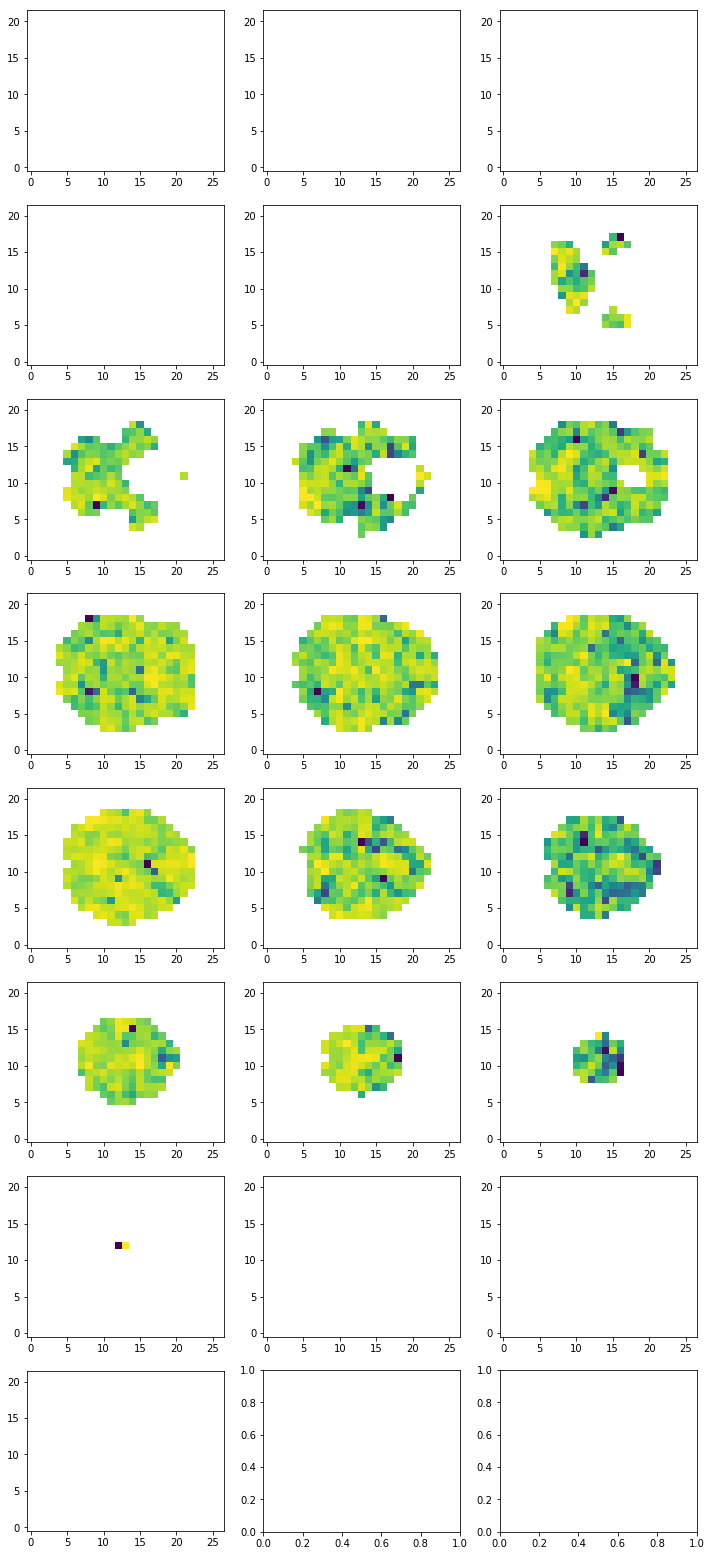

In [66]:
# Replace all zero values in the predictability map by NaN. 
predictability_map_with_nan = predictability_map.copy()
predictability_map_with_nan[predictability_map_with_nan == 0] = np.nan

# Display all the sections of the prectictability map with an axial view. 
nb_columns = 3
fig, axes = plt.subplots(nrows = np.ceil(predictability_map_with_nan.shape[2] / nb_columns).astype(int), 
                         ncols = nb_columns, figsize = (12, 28))

for slice_index in range(0, predictability_map_with_nan.shape[2]):
    axes[(slice_index // nb_columns), (slice_index % nb_columns)].imshow(predictability_map_with_nan[:, :, slice_index], origin = 'lower')

Here, we can see the **predictability level for each cluster of the brain**. While the structure of this predictability is not obvious, some patterns are noticeable after a careful inspection. For example, **clusters with high predictability have a certain tendency to be grouped together**, which might indicate the presence of large functional areas working in synchrony. Conversely, **clusters with low predictability are more isolated**, which is more difficult to interpret but might be interesting to explore from a scientific point of view. For example, since the subjects in our test set are entirely different from the subjects in our train set, we could imagine that these low-predictability clusters reflect strongly subject-specific processes: depending on the individual, these clusters might react very differently to the activity of the rest of the brain, explaining the low predicting power of our models. 

In [67]:
# Find the R^2 of the voxel or cluster with the maximum predictability. 
most_predictable_voxel = np.max(predictability_map)
most_predictable_voxel

0.9484880545743963

In [68]:
# Find the index of this voxel or cluster in the flatten array. 
most_predictable_voxel_flatten_idx = np.argmax(predictability_map)
most_predictable_voxel_flatten_idx

4956

In [69]:
# Find the indexes of this voxel or cluster in the 3D array. 
most_predictable_voxel_idx = np.unravel_index(np.argmax(predictability_map), predictability_map.shape)
most_predictable_voxel_idx

(8, 9, 6)

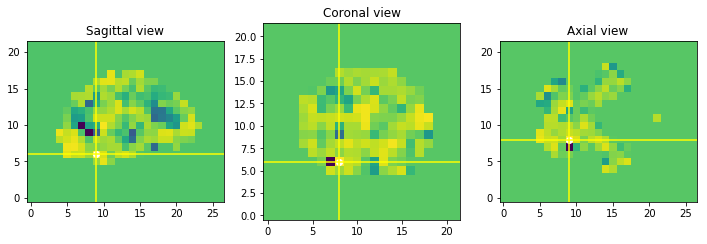

In [70]:
# Display the position of this voxel or cluster, taking the predictability map as background. 
display_voxel_or_cluster_position(most_predictable_voxel_idx, predictability_map, predictability_map.shape, ylim_correction = False)

In [71]:
# Find the R^2 of the voxel or cluster with the minimum predictability. 
least_predictable_voxel = np.min(predictability_map)
least_predictable_voxel

-5.615301484967126

In [72]:
# Find the index of this voxel or cluster in the flatten array. 
least_predictable_voxel_flatten_idx = np.argmin(predictability_map)
least_predictable_voxel_flatten_idx

6898

In [73]:
# Find the indexes of this voxel or cluster in the 3D array. 
least_predictable_voxel_idx = np.unravel_index(np.argmin(predictability_map), predictability_map.shape)
least_predictable_voxel_idx

(11, 16, 12)

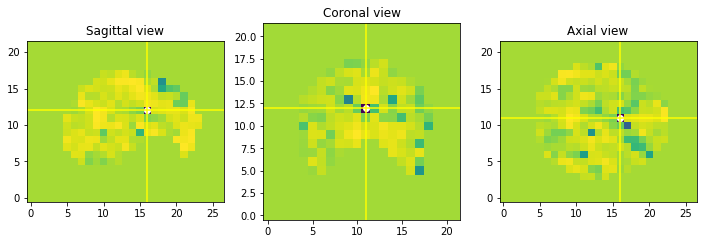

In [74]:
# Display the position of this voxel or cluster, taking the predictability map as background. 
display_voxel_or_cluster_position(least_predictable_voxel_idx, predictability_map, predictability_map.shape, ylim_correction = False)

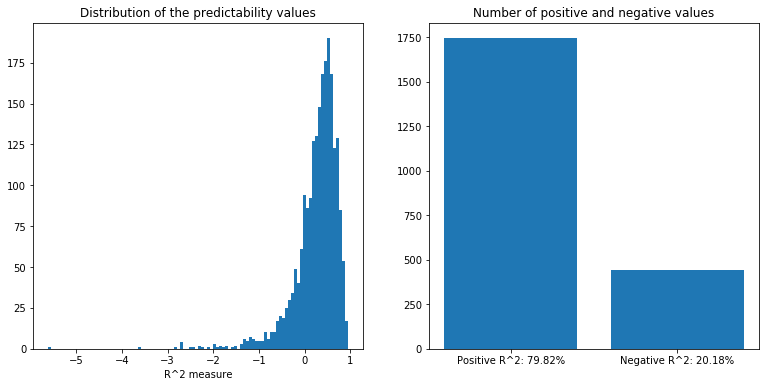

In [75]:
# Flatten the array and get the predictability values different from zero. 
predictability_values = predictability_map.flatten()
predictability_values = predictability_values[predictability_values != 0]

# Display a histogram of the predictability values of all voxels or clusters. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 6))
axes[0].hist(predictability_values, bins = 100)
axes[0].set_xlabel('R^2 measure')
axes[0].set_title('Distribution of the predictability values')
axes[1].bar([1, 2], [np.sum(predictability_values > 0), np.sum(predictability_values < 0)])
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['Positive R^2: ' + str(np.round(100 * np.sum(predictability_values > 0) / len(predictability_values), 2)) + '%',
                         'Negative R^2: ' + str(np.round(100 * np.sum(predictability_values < 0) / len(predictability_values), 2)) + '%'])
axes[1].set_title('Number of positive and negative values');

Here, we see that there is no R^2 value above 1, which is expected by construction of the R^2 measure. **Most of the time, the R^2 value is positive**, which implies that the activity of the cluster was predictable, at least partially, by the linear regression model. Nevertheless, **for a certain number of clusters, the R^2 value is negative**, which implies that the linear regression model performed worse than the baseline. 